In [1]:
!pip install langchain_community langchain langgraph langchain-openai openai

In [2]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


In [3]:
from pydantic import BaseModel, Field
from typing import List, Optional

class ToneAnalysisSchema(BaseModel):
    sentence: str = Field(..., description="The sentence or segment being analyzed for tone.")
    current_tone: str = Field(..., description="The identified tone of the sentence (e.g., formal, informal, emotional, technical).")
    change_needed: bool = Field(..., description="Whether a tone shift is necessary for this segment.")
    reason: str = Field(..., description="Explanation of why the tone shift is needed, if applicable.")

class ToneShiftSuggestionSchema(BaseModel):
    sentence: str = Field(..., description="The sentence or segment for which the tone shift is being suggested.")
    suggested_tone: str = Field(..., description="The target tone that should replace the current tone (e.g., formal, persuasive, technical).")
    suggestion: str = Field(..., description="The specific changes suggested to shift the tone, including word choices, sentence structures, etc.")
    position: int = Field(..., description="The position in the text where the tone shift suggestion applies.")

class ToneShiftImplementationSchema(BaseModel):
    original_sentence: str = Field(..., description="The original sentence before the tone shift was applied.")
    revised_sentence: str = Field(..., description="The sentence after the tone shift was applied.")
    final_review: str = Field(..., description="Evaluation of whether the tone shift was successful (yes/no).")
    review_notes: str = Field(..., description="Any notes or feedback on the success of the tone shift.")

In [4]:
class ToneAnalysisResponseSchema(BaseModel):
  tone_analysis: List[ToneAnalysisSchema] = Field(..., description="The tone analysis of the text")

class ToneShiftSuggestionSchema(BaseModel):
  tone_shift_suggestions: List[ToneShiftSuggestionSchema] = Field(..., description="The list of tone shift suggestions of the text")

class ToneShiftImplementationResponseSchema(BaseModel):
  tone_shift_implementation: List[ToneShiftImplementationSchema] = Field(..., description="The list of tone shift implementations of the text")
  final_text: str = Field(..., description="The final text of the text")
  final_review: str = Field(..., description="The final review of the text")
  review_notes: str = Field(..., description="The final review notes of the text")

class FinalCheckResponseSchema(BaseModel):
  final_check: str = Field(..., description="The final check to evaluate if the text passes all the criteria about tone shifting. You must only answer 'yes' or 'no' in lower case")

In [5]:
from typing import Dict, TypedDict, Optional

class GraphState(TypedDict):
    text: str
    lang: str
    target_tone: str

    tone_analysis: List[ToneAnalysisSchema]

    tone_shift_suggestions: List[ToneShiftSuggestionSchema]

    tone_shift_implementation: List[ToneShiftImplementationSchema]

    final_text: str
    final_review: str
    review_notes: str

    final_check: str

In [6]:
from langgraph.graph import StateGraph
workflow = StateGraph(GraphState)

In [7]:
from langchain_openai import ChatOpenAI
from langchain.schema import (
       AIMessage,
       HumanMessage,
       SystemMessage
  )

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)

In [8]:
from langchain_core.output_parsers import JsonOutputParser

def analyze_text_tone(state):
    json_parser = JsonOutputParser(pydantic_object=ToneAnalysisResponseSchema)

    target_tone = state['target_tone']

    messages = [
        SystemMessage(content=f"You are a tone analysis expert for {state['lang']} texts."),
        HumanMessage(content=f"""Please analyze the following text and identify the tone of each sentence.
        Indicate if the tone is formal, informal, persuasive, emotional, or neutral. Also, specify whether a tone shift is needed to achieve the target tone: {target_tone}.

        Text to analyze:
        {state['text']}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"STEP 1: Tone Analysis: {parsed_result}")

    return {
        "tone_analysis": parsed_result["tone_analysis"]
    }

In [9]:
from langchain_core.output_parsers import JsonOutputParser

def suggest_tone_shifts(state):
    json_parser = JsonOutputParser(pydantic_object=ToneShiftSuggestionSchema)

    messages = [
        SystemMessage(content=f"You are a tone shift suggester for {state['lang']} texts."),
        HumanMessage(content=f"""Based on the following tone analysis, please suggest specific changes to adjust the tone where necessary.
        The suggestions should include modifications to word choices, sentence structures, or overall style to achieve the desired tone.

        Tone Analysis:
        {state['tone_analysis']}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"STEP 2: Tone Shift Suggestions: {parsed_result}")

    return {
        "tone_shift_suggestions": parsed_result["tone_shift_suggestions"]
    }


In [10]:
from langchain_core.output_parsers import JsonOutputParser

def implement_tone_shifts(state):
    json_parser = JsonOutputParser(pydantic_object=ToneShiftImplementationResponseSchema)

    messages = [
        SystemMessage(content=f"You are a tone shift implementer for {state['lang']} texts."),
        HumanMessage(content=f"""Based on the following tone shift suggestions, please implement the suggested changes in the text.
        After implementing the changes, provide the final version of the text along with a review of whether the tone shift was successful or if further adjustments are needed.

        Tone Shift Suggestions:
        {state['tone_shift_suggestions']}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"STEP 3: Tone Shift Implementation: {parsed_result}")

    return {
        "tone_shift_implementation": parsed_result["tone_shift_implementation"],
        "final_text": parsed_result["final_text"],
        "final_review": parsed_result["final_review"],
        "review_notes": parsed_result["review_notes"]
    }


In [11]:
from langchain_core.output_parsers import JsonOutputParser

def perform_final_tone_check(state):
    json_parser = JsonOutputParser(pydantic_object=FinalCheckResponseSchema)

    messages = [
        SystemMessage(content=f"You are a final tone shift evaluator for {state['lang']} texts."),
        HumanMessage(content=f"""Please evaluate if the following text passes all the criteria for tone shifting.
        You must answer only 'yes' if the text meets the desired tone, and 'no' if it does not. Be precise in your judgment.

        Final Text to check:
        {state['final_text']}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    print(f"STEP 4: Final Tone Check: {parsed_result}")

    return {
        "final_check": parsed_result["final_check"]
    }


In [12]:
def decide_to_finish(state: GraphState):

    final_decision = state["final_check"]

    if final_decision == "yes":
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "no"

In [13]:
from langgraph.graph import END

workflow.add_node("analyze_text_tone", analyze_text_tone)
workflow.add_node("suggest_tone_shifts", suggest_tone_shifts)
workflow.add_node("implement_tone_shifts", implement_tone_shifts)
workflow.add_node("perform_final_tone_check", perform_final_tone_check)

workflow.set_entry_point("analyze_text_tone")
workflow.add_edge('analyze_text_tone', "suggest_tone_shifts")
workflow.add_edge('suggest_tone_shifts', "implement_tone_shifts")
workflow.add_edge('implement_tone_shifts', "perform_final_tone_check")

workflow.add_conditional_edges(
    "perform_final_tone_check",
    decide_to_finish,
    {
        "end": END,
        "no": "implement_tone_shifts",
    },
)

In [14]:
app = workflow.compile()

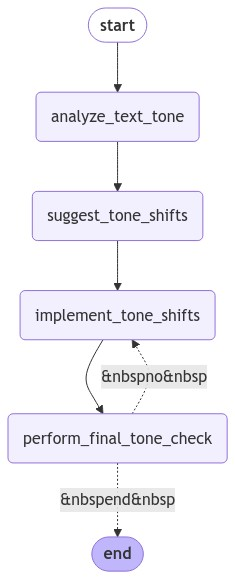

In [15]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [16]:
inputs = {
    "text": """
      Pues mira, un LLM es básicamente como un cerebro gigante que ha leído un montón de cosas de internet, libros, artículos, ¡todo lo que te puedas imaginar!
      Entonces, cuando le preguntas algo, no es que piense de verdad, pero usa toda esa información que tiene guardada para darte una respuesta que suene inteligente.
      Es como si juntara pedacitos de todo lo que ha leído para intentar entender qué le estás diciendo y responder de la mejor forma posible.
      O sea, no es que sepa realmente, pero hace como que sí. Eso sí, a veces suelta cosas que no tienen ni pies ni cabeza, pero la mayoría del tiempo te deja pensando
      ¡vaya, qué listo parece este!.
    """,
    "lang": "es",
    "target_tone": "formal"
    ""}

result = app.invoke(inputs)

STEP 1: Tone Analysis: {'tone_analysis': [{'sentence': 'Pues mira, un LLM es básicamente como un cerebro gigante que ha leído un montón de cosas de internet, libros, artículos, ¡todo lo que te puedas imaginar!', 'current_tone': 'informal', 'change_needed': True, 'reason': 'The tone is too casual for a formal discussion.'}, {'sentence': 'Entonces, cuando le preguntas algo, no es que piense de verdad, pero usa toda esa información que tiene guardada para darte una respuesta que suene inteligente.', 'current_tone': 'informal', 'change_needed': True, 'reason': 'The conversational tone detracts from a formal explanation.'}, {'sentence': 'Es como si juntara pedacitos de todo lo que ha leído para intentar entender qué le estás diciendo y responder de la mejor forma posible.', 'current_tone': 'informal', 'change_needed': True, 'reason': 'The simile and casual structure are inappropriate for a formal context.'}, {'sentence': 'O sea, no es que sepa realmente, pero hace como que sí.', 'current_to

In [17]:
result

{'text': '\n      Pues mira, un LLM es básicamente como un cerebro gigante que ha leído un montón de cosas de internet, libros, artículos, ¡todo lo que te puedas imaginar! \n      Entonces, cuando le preguntas algo, no es que piense de verdad, pero usa toda esa información que tiene guardada para darte una respuesta que suene inteligente. \n      Es como si juntara pedacitos de todo lo que ha leído para intentar entender qué le estás diciendo y responder de la mejor forma posible. \n      O sea, no es que sepa realmente, pero hace como que sí. Eso sí, a veces suelta cosas que no tienen ni pies ni cabeza, pero la mayoría del tiempo te deja pensando \n      ¡vaya, qué listo parece este!.\n    ',
 'lang': 'es',
 'target_tone': 'formal',
 'tone_analysis': [{'sentence': 'Pues mira, un LLM es básicamente como un cerebro gigante que ha leído un montón de cosas de internet, libros, artículos, ¡todo lo que te puedas imaginar!',
   'current_tone': 'informal',
   'change_needed': True,
   'reason